In [12]:
# -------------------------------------------------------------------
# Unigram Diversity - Word Cloud Contrasting
# -------------------------------------------------------------------

import json
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np

def extract_email_text(data):
    """Extract text from email JSON structure"""
    all_text = []
    
    for item in data:
        if 'email_chain' in item:
            for email in item['email_chain']:
                if 'body' in email:
                    all_text.append(email['body'])
        elif 'emails' in item:
            for email in item['emails']:
                if 'body' in email:
                    all_text.append(email['body'])
    
    return ' '.join(all_text)

def clean_email_text(text):
    """Clean text specifically for email content"""
    text = re.sub(r'Dear\s+\w+[,.]?', '', text, flags=re.IGNORECASE)
    text = re.sub(r'(Best\s+)?Regards[,.]?', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Sincerely[,.]?', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Thank\s+you', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Thanks', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Hi\s+\w+[,.]?', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Hello\s+\w+[,.]?', '', text, flags=re.IGNORECASE)
    
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '', text)
    text = re.sub(r'\d{2}:\d{2}', '', text)
    
    text = re.sub(r'[^\w\s\'-]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.lower()

def maritime_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    """Color function for maritime theme"""
    # Check if word is a key maritime term
    key_maritime_terms = {
        'vessel', 'cargo', 'port', 'charter', 'freight', 'shipping', 
        'container', 'tanker', 'bulk', 'terminal', 'berth', 'tonnage',
        'laytime', 'demurrage', 'voyage', 'loading', 'discharge', 'bunker'
    }
    
    if word.lower() in key_maritime_terms:
        colors = [(0, 60, 100), (0, 86, 119), (25, 94, 131)]
    else:
        colors = [(72, 185, 213), (100, 200, 220), (120, 210, 230)]
    
    idx = np.random.randint(0, len(colors))
    return f"rgb{colors[idx]}"

def create_email_wordclouds_comparison(refined_path, zeroshot_path, output_path='email_wordcloud_comparison.png'):
    """Create side-by-side word clouds for refined vs zero-shot emails"""
    
    print("Loading refined emails...")
    with open(refined_path, 'r', encoding='utf-8') as f:
        refined_data = json.load(f)
    
    print("Loading zero-shot emails...")
    with open(zeroshot_path, 'r', encoding='utf-8') as f:
        zeroshot_data = json.load(f)
    
    refined_text = extract_email_text(refined_data)
    zeroshot_text = extract_email_text(zeroshot_data)
    
    refined_text = clean_email_text(refined_text)
    zeroshot_text = clean_email_text(zeroshot_text)
    
    custom_stopwords = set(STOPWORDS)
    email_stopwords = {
        'email', 'please', 'would', 'could', 'should', 'will', 'can', 
        'may', 'might', 'must', 'shall', 'need', 'want', 'know', 'let',
        'get', 'got', 'have', 'has', 'had', 'make', 'made', 'see', 'look',
        'looking', 'forward', 'back', 'us', 'we', 'our', 'your', 'you',
        'me', 'my', 'mr', 'mrs', 'ms', 'sir', 'madam', 'regarding',
        'concerning', 'about', 'also', 'however', 'therefore', 'thus',
        'one', 'two', 'three', 'first', 'second', 'last', 'next',
        'yes', 'no', 'ok', 'okay', 'sure', 'hope', 'well', 'good',
        'best', 'kind', 'new', 'old', 'time', 'day', 'week', 'month',
        'attached', 'attachment', 'document', 'file', 'copy', 'cc',
        'subject', 're', 'fwd', 'sent', 'from', 'to', 'date'
    }
    custom_stopwords.update(email_stopwords)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    print("Generating refined emails word cloud...")
    wordcloud_refined = WordCloud(
        width=1600,
        height=800,
        background_color='white',
        stopwords=custom_stopwords,
        max_words=100,
        relative_scaling=0.6,
        min_font_size=14,
        max_font_size=120,
        prefer_horizontal=0.7,
        color_func=maritime_color_func,
        collocations=True,
        random_state=42
    ).generate(refined_text)
    
    print("Generating zero-shot emails word cloud...")
    wordcloud_zeroshot = WordCloud(
        width=1600,
        height=800,
        background_color='white',
        stopwords=custom_stopwords,
        max_words=100,
        relative_scaling=0.6,
        min_font_size=14,
        max_font_size=120,
        prefer_horizontal=0.7,
        colormap='Oranges',
        collocations=True,
        random_state=42
    ).generate(zeroshot_text)
    
    ax1.imshow(wordcloud_refined, interpolation='bilinear')
    ax1.set_title('BARE Llama-8B (Claude)', fontsize=24, fontweight='bold', pad=20)
    ax1.axis('off')
    
    ax2.imshow(wordcloud_zeroshot, interpolation='bilinear')
    ax2.set_title('Zero-shot (DeepSeek)', fontsize=24, fontweight='bold', pad=20)
    ax2.axis('off')    
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"Word cloud comparison saved to: {output_path}")
    
    return wordcloud_refined, wordcloud_zeroshot

if __name__ == "__main__":
    refined_path = "../data/email_datasets/synthetic/baserefine/refine/llama8b/claude/aggregated/aggregated.json"
    zeroshot_path = "../data/email_datasets/synthetic/zeroshot/deepseek/aggregated/aggregated.json"    
    create_email_wordclouds_comparison(refined_path, zeroshot_path)    

Loading refined emails...
Loading zero-shot emails...
Generating refined emails word cloud...
Generating zero-shot emails word cloud...
Word cloud comparison saved to: email_wordcloud_comparison.png


In [ ]:
# -------------------------------------------------------------------
# Sankey Diagram - Sentiment Change
# -------------------------------------------------------------------
import pandas as pd
import json
import os

class EmailChainMatcher:
    """Match input and output email chains using batch mapping"""
    
    def __init__(self, base_dir: str):
        self.base_dir = Path(base_dir)
        self.input_dir = self.base_dir / "input"
        self.output_dir = self.base_dir / "processed"
        self.batch_mapping = {}
        self.matched_data = []
        
    def load_batch_mapping(self):
        """Load the mapping between input batches and output files"""
        completed_file = self.base_dir / "completed_batch_jobs.json"
        
        if completed_file.exists():
            with open(completed_file, 'r') as f:
                completed_batches = json.load(f)
                
            for batch_info in completed_batches:
                batch_id = batch_info.get('batch_id', '')
                output_file = batch_info.get('output', '')
                
                input_file = f"{batch_id}.jsonl"
                if (self.input_dir / input_file).exists():
                    self.batch_mapping[input_file] = output_file
                    print(f"Mapped: {input_file} -> {output_file}")
        
        print(f"\nTotal batch mappings: {len(self.batch_mapping)}")
    
    def extract_unrefined_email(self, content: str) -> str:
        """Extract the unrefined email chain from the input content"""
        # Find the email chain section
        start_marker = "Unrefined email chain:"
        end_marker = "---\n\n            Formatting requirements:"
        
        start_idx = content.find(start_marker)
        if start_idx == -1:
            return ""
            
        start_idx += len(start_marker)
        
        end_idx = content.find(end_marker, start_idx)
        if end_idx == -1:
            end_marker = "---"
            end_idx = content.find(end_marker, start_idx)
        
        if end_idx == -1:
            return content[start_idx:].strip()
        
        return content[start_idx:end_idx].strip()
    
    def clean_json_response(self, response: str) -> dict:
        """Clean and parse JSON from the response string"""
        cleaned = response.strip()
        cleaned = re.sub(r'^```json\s*', '', cleaned)
        cleaned = re.sub(r'\s*```$', '', cleaned)
        
        start = cleaned.find('{')
        end = cleaned.rfind('}')
        
        if start != -1 and end != -1:
            cleaned = cleaned[start:end + 1]
        
        try:
            return json.loads(cleaned)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
            print(f"Attempted to parse: {cleaned[:200]}...")
            return None
    
    def format_email_chain_text(self, email_chain: list) -> str:
        """Format email chain list into readable text"""
        if not email_chain:
            return ""
        
        formatted_emails = []
        for email in email_chain:
            email_text = f"From: {email.get('from', 'N/A')}\n"
            email_text += f"To: {email.get('to', 'N/A')}\n"
            email_text += f"Subject: {email.get('subject', 'N/A')}\n"
            email_text += f"Timestamp: {email.get('timestamp', 'N/A')}\n"
            email_text += f"Body: {email.get('body', 'N/A')}"
            formatted_emails.append(email_text)
        
        return "\n\n---\n\n".join(formatted_emails)
    
    def process_batch_pair(self, input_file: str, output_file: str):
        """Process a matched pair of input and output files"""
        input_path = self.input_dir / input_file
        output_path = self.output_dir / output_file
        
        if not input_path.exists() or not output_path.exists():
            print(f"Missing files: {input_file} or {output_file}")
            return
        
        print(f"\nProcessing batch pair:")
        print(f"  Input: {input_file}")
        print(f"  Output: {output_file}")
        
        input_requests = []
        with open(input_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f):
                try:
                    data = json.loads(line.strip())
                    custom_id = data.get('custom_id')
                    
                    messages = data.get('params', {}).get('messages', [])
                    if messages and len(messages) > 0:
                        content = messages[0].get('content', '')
                        unrefined_email = self.extract_unrefined_email(content)
                        
                        input_requests.append({
                            'custom_id': custom_id,
                            'unrefined_email': unrefined_email,
                            'line_num': line_num
                        })
                except Exception as e:
                    print(f"  Error reading line {line_num}: {e}")
        
        print(f"  Loaded {len(input_requests)} input requests")
        
        output_responses = []
        with open(output_path, 'r', encoding='utf-8') as f:
            try:
                raw_responses = json.load(f)
                
                if isinstance(raw_responses, list):
                    for idx, response in enumerate(raw_responses):
                        if isinstance(response, str):
                            parsed = self.clean_json_response(response)
                            if parsed and 'email_chain' in parsed:
                                output_responses.append({
                                    'email_chain': parsed['email_chain'],
                                    'labels': parsed.get('labels', {}),
                                    'formatted_text': self.format_email_chain_text(parsed['email_chain'])
                                })
                            else:
                                output_responses.append({
                                    'email_chain': [],
                                    'labels': {},
                                    'formatted_text': f"Error parsing response {idx}"
                                })
                        else:
                            print(f"  Unexpected response type at index {idx}: {type(response)}")
                
            except Exception as e:
                print(f"  Error loading output file: {e}")
        
        print(f"  Loaded {len(output_responses)} output responses")
        
        matches = min(len(input_requests), len(output_responses))
        print(f"  Matching {matches} entries")
        
        for i in range(matches):
            input_data = input_requests[i]
            output_data = output_responses[i]
            
            self.matched_data.append({
                'custom_id': input_data['custom_id'],
                'input_file': input_file,
                'output_file': output_file,
                'input_text': input_data['unrefined_email'],
                'output_text': output_data['formatted_text'],
                'output_json': output_data['email_chain'],
                'labels': output_data['labels']
            })
    
    def process_all_batches(self):
        """Process all matched batch pairs"""
        self.load_batch_mapping()
        
        if not self.batch_mapping:
            print("No batch mappings found!")
            return
        
        for input_file, output_file in self.batch_mapping.items():
            self.process_batch_pair(input_file, output_file)
        
        print(f"\nTotal matched entries: {len(self.matched_data)}")
    
    def create_dataframe(self) -> pd.DataFrame:
        """Create a pandas DataFrame from matched data"""
        if not self.matched_data:
            print("No matched data to create DataFrame")
            return pd.DataFrame()
        
        df = pd.DataFrame(self.matched_data)
        
        try:
            df['custom_id_int'] = df['custom_id'].astype(int)
            df = df.sort_values('custom_id_int').drop('custom_id_int', axis=1)
        except:
            df = df.sort_values('custom_id')
        
        return df
    
    def save_results(self, output_path: str):
        """Save the matched data in multiple formats"""
        df = self.create_dataframe()
        
        if df.empty:
            print("No data to save")
            return
        
        csv_columns = ['custom_id', 'input_file', 'output_file', 'input_text', 'output_text']
        df[csv_columns].to_csv(output_path, index=False)
        print(f"\nSaved CSV to: {output_path}")
        
        simple_path = output_path.replace('.csv', '_simple.csv')
        df[['custom_id', 'input_text', 'output_text']].to_csv(simple_path, index=False)
        print(f"Saved simple CSV to: {simple_path}")
        
        json_path = output_path.replace('.csv', '_complete.json')
        df.to_json(json_path, orient='records', indent=2)
        print(f"Saved complete JSON to: {json_path}")

def main(base_dir: str) -> pd.DataFrame:    
    matcher = EmailChainMatcher(base_dir)
    
    matcher.process_all_batches()
    
    output_path = os.path.join(base_dir, "matched_emails_correct.csv")
    matcher.save_results(output_path)
    
    return matcher.create_dataframe()

# Matching Base and Refined Emails
base_dir = "../data/email_datasets/synthetic/baserefine/refine/llama3b/claude"
df = main(base_dir)

In [52]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from pathlib import Path

from analytics.sentiment_analysis import EmailPreprocessor, EnsembleSentimentAnalyzer

class MatchedEmailSentimentAnalyzer:
    """Analyze sentiment changes between input and output emails"""
    
    def __init__(self):
        self.preprocessor = EmailPreprocessor()
        self.analyzer = EnsembleSentimentAnalyzer()
        
    def split_email_chain(self, chain_text: str) -> List[str]:
        """
        Split a chain text containing multiple emails into individual email texts.
        Using the exact pattern from your BaseChainsAnalyzer.
        """
        email_pattern = r'(?:<)?Email\s*\d+(?:>)?:\s*'        
        emails = re.split(email_pattern, chain_text)
        emails = [email.strip() for email in emails if email.strip()]
        return emails
    
    def extract_bodies_from_structured_output(self, output_text: str) -> List[str]:
        """
        Extract email bodies from structured output format with From/To/Subject/Body fields.
        """
        bodies = []
        
        emails = output_text.split('---')
        
        for email in emails:
            email = email.strip()
            if not email:
                continue
                
            lines = email.split('\n')
            body_found = False
            body_lines = []
            
            for line in lines:
                if line.startswith('Body:'):
                    body_found = True
                    body_content = line[5:].strip()
                    if body_content:
                        body_lines.append(body_content)
                elif body_found and line.strip():
                    body_lines.append(line.strip())
                elif body_found and not line.strip() and len(body_lines) > 0:
                    continue
            
            if body_lines:
                full_body = ' '.join(body_lines)
                bodies.append(full_body)
        
        return bodies
    
    def process_email_chain(self, chain_text: str) -> Dict:
        """
        Process an email chain with Email X: format and compute sentiment.
        """
        emails = self.split_email_chain(chain_text)
        
        processed_emails = []
        individual_sentiments = []
        
        for i, email in enumerate(emails):
            processed_email = self.preprocessor.process_email(email)
            if processed_email.strip():
                processed_emails.append(processed_email)
                
                sentiment = self.analyzer.predict_sentiment(processed_email)
                individual_sentiments.append(sentiment)
        
        aggregated_text = " ".join(processed_emails)
        
        if not aggregated_text:
            chain_sentiment = {
                "sentiment_neg": 0.0,
                "sentiment_neu": 1.0,
                "sentiment_pos": 0.0
            }
        else:
            chain_sentiment = self.analyzer.predict_sentiment(aggregated_text)
        
        return {
            "chain_sentiment": chain_sentiment,
            "individual_sentiments": individual_sentiments,
            "num_emails": len(processed_emails)
        }
    
    def process_output_chain(self, output_text: str) -> Dict:
        """
        Process output email chain which has structured format with From/To/Subject/Body.
        """
        bodies = self.extract_bodies_from_structured_output(output_text)
        
        processed_emails = []
        individual_sentiments = []
        
        for i, body in enumerate(bodies):
            processed_email = self.preprocessor.process_email(body)
            if processed_email.strip():
                processed_emails.append(processed_email)
                
                sentiment = self.analyzer.predict_sentiment(processed_email)
                individual_sentiments.append(sentiment)
        
        aggregated_text = " ".join(processed_emails)
        
        if not aggregated_text:
            chain_sentiment = {
                "sentiment_neg": 0.0,
                "sentiment_neu": 1.0,
                "sentiment_pos": 0.0
            }
        else:
            chain_sentiment = self.analyzer.predict_sentiment(aggregated_text)
        
        return {
            "chain_sentiment": chain_sentiment,
            "individual_sentiments": individual_sentiments,
            "num_emails": len(processed_emails)
        }
    
    def get_sentiment_category(self, sentiment: Dict) -> str:
        """Determine sentiment category based on probabilities"""
        if sentiment['sentiment_pos'] > max(sentiment['sentiment_neg'], sentiment['sentiment_neu']):
            return 'Positive'
        elif sentiment['sentiment_neg'] > max(sentiment['sentiment_pos'], sentiment['sentiment_neu']):
            return 'Negative'
        else:
            return 'Neutral'
    
    def process_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process dataframe with matched input/output emails"""
        print(f"Initial dataframe size: {len(df)}")
        df_filtered = df[~df['output_text'].str.contains('Error parsing response', na=False)].copy()
        print(f"After filtering errors: {len(df_filtered)} entries remaining ({len(df) - len(df_filtered)} errors removed)")
        
        df_processed = df_filtered.copy()
        
        print("Processing emails using your sentiment pipeline...")
        
        sentiment_cols = ['input_sentiment_neg', 'input_sentiment_neu', 'input_sentiment_pos',
                         'output_sentiment_neg', 'output_sentiment_neu', 'output_sentiment_pos']
        for col in sentiment_cols:
            df_processed[col] = 0.0
        
        for idx, row in df_processed.iterrows():
            if idx % 10 == 0:
                print(f"Processing email {idx+1}/{len(df_processed)}")
            
            input_text = str(row.get('input_text', ''))
            if input_text and input_text != 'nan':
                input_result = self.process_email_chain(input_text)
                input_sentiment = input_result['chain_sentiment']
                df_processed.at[idx, 'input_sentiment_neg'] = input_sentiment['sentiment_neg']
                df_processed.at[idx, 'input_sentiment_neu'] = input_sentiment['sentiment_neu']
                df_processed.at[idx, 'input_sentiment_pos'] = input_sentiment['sentiment_pos']
            
            output_text = str(row.get('output_text', ''))
            if output_text and output_text != 'nan':
                output_result = self.process_output_chain(output_text)
                output_sentiment = output_result['chain_sentiment']
                df_processed.at[idx, 'output_sentiment_neg'] = output_sentiment['sentiment_neg']
                df_processed.at[idx, 'output_sentiment_neu'] = output_sentiment['sentiment_neu']
                df_processed.at[idx, 'output_sentiment_pos'] = output_sentiment['sentiment_pos']
        
        df_processed['input_sentiment_category'] = df_processed.apply(
            lambda row: self.get_sentiment_category({
                'sentiment_neg': row['input_sentiment_neg'],
                'sentiment_neu': row['input_sentiment_neu'],
                'sentiment_pos': row['input_sentiment_pos']
            }), axis=1
        )
        
        df_processed['output_sentiment_category'] = df_processed.apply(
            lambda row: self.get_sentiment_category({
                'sentiment_neg': row['output_sentiment_neg'],
                'sentiment_neu': row['output_sentiment_neu'],
                'sentiment_pos': row['output_sentiment_pos']
            }), axis=1
        )
        
        df_processed['category_change'] = (
            df_processed['input_sentiment_category'] + ' → ' + df_processed['output_sentiment_category']
        )
        
        return df_processed
    
    def create_static_sankey(self, df_processed: pd.DataFrame, save_path: str = None):
        """Create a static Sankey diagram using matplotlib"""
        # Count transitions
        transitions = df_processed['category_change'].value_counts()
        total_count = len(df_processed)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        left_x = 0.15
        right_x = 0.85
        positions = {'Negative': 0.7, 'Neutral': 0.5, 'Positive': 0.3}
        
        colors = {
            'Negative': '#e74c3c',
            'Neutral': '#95a5a6',
            'Positive': '#27ae60'
        }
        
        input_counts = df_processed['input_sentiment_category'].value_counts()
        output_counts = df_processed['output_sentiment_category'].value_counts()
        
        box_width = 0.06
        max_height = 0.25
        
        for sentiment in ['Negative', 'Neutral', 'Positive']:
            count = input_counts.get(sentiment, 0)
            if count > 0:
                height = (count / total_count) * max_height * 2
                y_pos = positions[sentiment]
                
                rect = plt.Rectangle((left_x - box_width/2, y_pos - height/2), 
                                   box_width, height, 
                                   facecolor=colors[sentiment], 
                                   edgecolor='black', 
                                   linewidth=1.5,
                                   zorder=5)
                ax.add_patch(rect)
                
                percentage = (count / total_count * 100) if total_count > 0 else 0
                ax.text(left_x - box_width/2 - 0.02, y_pos, 
                       f'{sentiment}\n{count}\n({percentage:.1f}%)', 
                       ha='right', va='center', fontsize=10, fontweight='bold')
        
        for sentiment in ['Negative', 'Neutral', 'Positive']:
            count = output_counts.get(sentiment, 0)
            if count > 0:
                height = (count / total_count) * max_height * 2
                y_pos = positions[sentiment]
                
                rect = plt.Rectangle((right_x - box_width/2, y_pos - height/2), 
                                   box_width, height, 
                                   facecolor=colors[sentiment], 
                                   edgecolor='black', 
                                   linewidth=1.5,
                                   zorder=5)
                ax.add_patch(rect)
                
                percentage = (count / total_count * 100) if total_count > 0 else 0
                ax.text(right_x + box_width/2 + 0.02, y_pos, 
                       f'{sentiment}\n{count}\n({percentage:.1f}%)', 
                       ha='left', va='center', fontsize=10, fontweight='bold')
        
        for transition, count in transitions.items():
            if count == 0:
                continue
                
            source_sent, target_sent = transition.split(' → ')
            source_y = positions[source_sent]
            target_y = positions[target_sent]
            
            flow_width = (count / total_count) * max_height
            
            if source_sent == target_sent:
                flow_color = colors[source_sent]
                alpha = 0.4
            else:
                flow_color = '#7f8c8d'
                alpha = 0.3
            
            num_points = 100
            t = np.linspace(0, 1, num_points)
            
            x1, y1 = left_x + box_width/2, source_y
            x2, y2 = right_x - box_width/2, target_y
            
            ctrl1_x = x1 + (x2 - x1) * 0.3
            ctrl1_y = y1
            ctrl2_x = x1 + (x2 - x1) * 0.7
            ctrl2_y = y2
            
            x = (1-t)**3 * x1 + 3*(1-t)**2*t * ctrl1_x + 3*(1-t)*t**2 * ctrl2_x + t**3 * x2
            y = (1-t)**3 * y1 + 3*(1-t)**2*t * ctrl1_y + 3*(1-t)*t**2 * ctrl2_y + t**3 * y2
            
            ax.fill_between(x, y - flow_width/2, y + flow_width/2, 
                          color=flow_color, alpha=alpha, edgecolor='none', zorder=1)
            
            if count > total_count * 0.02:
                mid_x = (x1 + x2) / 2
                mid_y = (y1 + y2) / 2
                percentage = (count / total_count * 100)
                ax.text(mid_x, mid_y, f'{count}\n({percentage:.1f}%)', 
                       ha='center', va='center', fontsize=8,
                       bbox=dict(boxstyle="round,pad=0.3", 
                               facecolor='white', alpha=0.8, edgecolor='none'),
                       zorder=10)
        
        ax.text(left_x, 0.9, 'Base Emails', ha='center', va='center', 
               fontsize=14, fontweight='bold')
        ax.text(right_x, 0.9, 'Refined Emails', ha='center', va='center', 
               fontsize=14, fontweight='bold')
                
        sentiment_changes = []
        for _, row in df_processed.iterrows():
            input_scores = {
                'neg': row['input_sentiment_neg'],
                'neu': row['input_sentiment_neu'],
                'pos': row['input_sentiment_pos']
            }
            output_scores = {
                'neg': row['output_sentiment_neg'],
                'neu': row['output_sentiment_neu'],
                'pos': row['output_sentiment_pos']
            }
            
            input_compound = input_scores['pos'] - input_scores['neg']
            output_compound = output_scores['pos'] - output_scores['neg']
            change = output_compound - input_compound
            sentiment_changes.append(change)
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        
        plt.tight_layout()
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Sankey diagram saved to: {save_path}")
                
        return fig


def analyze_matched_emails_with_sankey(df: pd.DataFrame, save_path: str = None):
    """
    Main function to analyze matched emails and display Sankey diagram
    
    Args:
        df: DataFrame with 'input_text' and 'output_text' columns
        save_path: Optional path to save the Sankey diagram
    """
    analyzer = MatchedEmailSentimentAnalyzer()
    
    print("Analyzing sentiment using your pipeline logic...")
    df_processed = analyzer.process_dataframe(df)
    
    print("\n" + "="*60)
    print("SENTIMENT ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"\nTotal email chains analyzed: {len(df_processed)}")
    
    print("\nInput Sentiment Distribution:")
    input_dist = df_processed['input_sentiment_category'].value_counts()
    for cat, count in input_dist.items():
        print(f"  {cat}: {count} ({count/len(df_processed)*100:.1f}%)")
    
    print("\nOutput Sentiment Distribution:")
    output_dist = df_processed['output_sentiment_category'].value_counts()
    for cat, count in output_dist.items():
        print(f"  {cat}: {count} ({count/len(df_processed)*100:.1f}%)")
    
    print("\nSentiment Transitions:")
    transitions = df_processed['category_change'].value_counts()
    for trans, count in transitions.head(10).items():
        print(f"  {trans}: {count} ({count/len(df_processed)*100:.1f}%)")
    
    print("\nGenerating Sankey diagram...")
    analyzer.create_static_sankey(df_processed, save_path)
    
    return df_processed

Analyzing sentiment using your pipeline logic...
Initial dataframe size: 1000
After filtering errors: 991 entries remaining (9 errors removed)
Processing emails using your sentiment pipeline...
Processing email 1/991
Processing email 11/991
Processing email 21/991
Processing email 31/991
Processing email 41/991
Processing email 51/991
Processing email 711/991
Processing email 61/991
Processing email 71/991
Processing email 721/991
Processing email 81/991
Processing email 731/991
Processing email 91/991
Processing email 741/991
Processing email 751/991
Processing email 101/991
Processing email 111/991
Processing email 761/991
Processing email 771/991
Processing email 121/991
Processing email 131/991
Processing email 141/991
Processing email 791/991
Processing email 151/991
Processing email 801/991
Processing email 161/991
Processing email 811/991
Processing email 171/991
Processing email 821/991
Processing email 181/991
Processing email 831/991
Processing email 841/991
Processing email 

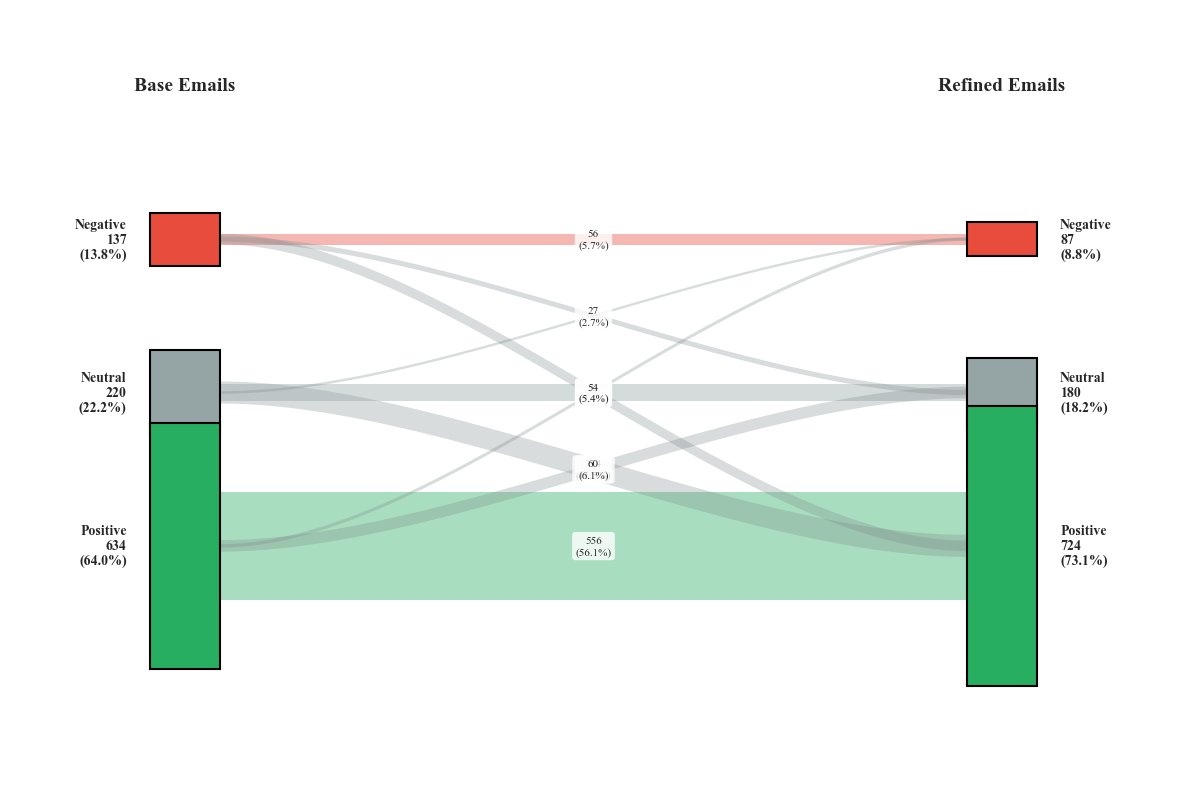

In [54]:
df_processed = analyze_matched_emails_with_sankey(df, save_path="claude_llama3b_sankey.png")

In [ ]:
# -------------------------------------------------------------------
# Sankey Diagram - Sentiment Change (GPT-4-Turbo)
# -------------------------------------------------------------------
import pandas as pd
import json
import os
import re
from pathlib import Path

class EmailChainMatcher:
    """Match input and output email chains using batch mapping"""
    
    def __init__(self, base_dir: str):
        self.base_dir = Path(base_dir)
        self.input_dir = self.base_dir / "input"
        self.output_dir = self.base_dir / "processed"
        self.batch_mapping = {}
        self.matched_data = []
        
    def load_batch_mapping(self):
        """Load the mapping between input batches and output files"""
        completed_file = self.base_dir / "completed_batch_jobs.json"
        
        if completed_file.exists():
            with open(completed_file, 'r') as f:
                completed_batches = json.load(f)
                
            for batch_info in completed_batches:
                batch_id = batch_info.get('batch_id', '')
                output_file = batch_info.get('output', '')
                
                input_file = f"{batch_id}.jsonl"
                if (self.input_dir / input_file).exists():
                    self.batch_mapping[input_file] = output_file
                    print(f"Mapped: {input_file} -> {output_file}")
        
        print(f"\nTotal batch mappings: {len(self.batch_mapping)}")
    
    def extract_unrefined_email(self, content: str) -> str:
        """Extract the unrefined email chain from the input content"""
        # Find the email chain section
        start_marker = "Unrefined email chain:"
        end_marker = "---\n\n            Formatting requirements:"
        
        start_idx = content.find(start_marker)
        if start_idx == -1:
            return ""
            
        start_idx += len(start_marker)
        
        end_idx = content.find(end_marker, start_idx)
        if end_idx == -1:
            end_marker = "---"
            end_idx = content.find(end_marker, start_idx)
        
        if end_idx == -1:
            return content[start_idx:].strip()
        
        return content[start_idx:end_idx].strip()
    
    def clean_json_response(self, response: str) -> dict:
        """Clean and parse JSON from the response string"""
        cleaned = response.strip()
        cleaned = re.sub(r'^```json\s*', '', cleaned)
        cleaned = re.sub(r'\s*```$', '', cleaned)
        
        start = cleaned.find('{')
        end = cleaned.rfind('}')
        
        if start != -1 and end != -1:
            cleaned = cleaned[start:end + 1]
        
        try:
            return json.loads(cleaned)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
            print(f"Attempted to parse: {cleaned[:200]}...")
            return None
    
    def format_email_chain_text(self, email_chain: list) -> str:
        """Format email chain list into readable text"""
        if not email_chain:
            return ""
        
        formatted_emails = []
        for email in email_chain:
            email_text = f"From: {email.get('from', 'N/A')}\n"
            email_text += f"To: {email.get('to', 'N/A')}\n"
            email_text += f"Subject: {email.get('subject', 'N/A')}\n"
            email_text += f"Timestamp: {email.get('timestamp', 'N/A')}\n"
            email_text += f"Body: {email.get('body', 'N/A')}"
            formatted_emails.append(email_text)
        
        return "\n\n---\n\n".join(formatted_emails)
    
    def process_batch_pair(self, input_file: str, output_file: str):
        """Process a matched pair of input and output files"""
        input_path = self.input_dir / input_file
        output_path = self.output_dir / output_file
        
        if not input_path.exists() or not output_path.exists():
            print(f"Missing files: {input_file} or {output_file}")
            return
        
        print(f"\nProcessing batch pair:")
        print(f"  Input: {input_file}")
        print(f"  Output: {output_file}")
        
        input_requests = []
        with open(input_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f):
                try:
                    data = json.loads(line.strip())
                    custom_id = data.get('custom_id')
                    
                    # GPT-4 format has messages under 'body' instead of 'params'
                    messages = data.get('body', {}).get('messages', [])
                    if messages and len(messages) > 0:
                        content = messages[0].get('content', '')
                        unrefined_email = self.extract_unrefined_email(content)
                        
                        input_requests.append({
                            'custom_id': custom_id,
                            'unrefined_email': unrefined_email,
                            'line_num': line_num
                        })
                except Exception as e:
                    print(f"  Error reading line {line_num}: {e}")
        
        print(f"  Loaded {len(input_requests)} input requests")
        
        output_responses = []
        with open(output_path, 'r', encoding='utf-8') as f:
            try:
                raw_responses = json.load(f)
                
                if isinstance(raw_responses, list):
                    for idx, response in enumerate(raw_responses):
                        if isinstance(response, str):
                            parsed = self.clean_json_response(response)
                            if parsed and 'email_chain' in parsed:
                                output_responses.append({
                                    'email_chain': parsed['email_chain'],
                                    'labels': parsed.get('labels', {}),
                                    'formatted_text': self.format_email_chain_text(parsed['email_chain'])
                                })
                            else:
                                output_responses.append({
                                    'email_chain': [],
                                    'labels': {},
                                    'formatted_text': f"Error parsing response {idx}"
                                })
                        else:
                            print(f"  Unexpected response type at index {idx}: {type(response)}")
                
            except Exception as e:
                print(f"  Error loading output file: {e}")
        
        print(f"  Loaded {len(output_responses)} output responses")
        
        matches = min(len(input_requests), len(output_responses))
        print(f"  Matching {matches} entries")
        
        for i in range(matches):
            input_data = input_requests[i]
            output_data = output_responses[i]
            
            self.matched_data.append({
                'custom_id': input_data['custom_id'],
                'input_file': input_file,
                'output_file': output_file,
                'input_text': input_data['unrefined_email'],
                'output_text': output_data['formatted_text'],
                'output_json': output_data['email_chain'],
                'labels': output_data['labels']
            })
    
    def process_all_batches(self):
        """Process all matched batch pairs"""
        self.load_batch_mapping()
        
        if not self.batch_mapping:
            print("No batch mappings found!")
            return
        
        for input_file, output_file in self.batch_mapping.items():
            self.process_batch_pair(input_file, output_file)
        
        print(f"\nTotal matched entries: {len(self.matched_data)}")
    
    def create_dataframe(self) -> pd.DataFrame:
        """Create a pandas DataFrame from matched data"""
        if not self.matched_data:
            print("No matched data to create DataFrame")
            return pd.DataFrame()
        
        df = pd.DataFrame(self.matched_data)
        
        try:
            df['custom_id_int'] = df['custom_id'].astype(int)
            df = df.sort_values('custom_id_int').drop('custom_id_int', axis=1)
        except:
            df = df.sort_values('custom_id')
        
        return df
    
    def save_results(self, output_path: str):
        """Save the matched data in multiple formats"""
        df = self.create_dataframe()
        
        if df.empty:
            print("No data to save")
            return
        
        csv_columns = ['custom_id', 'input_file', 'output_file', 'input_text', 'output_text']
        df[csv_columns].to_csv(output_path, index=False)
        print(f"\nSaved CSV to: {output_path}")
        
        simple_path = output_path.replace('.csv', '_simple.csv')
        df[['custom_id', 'input_text', 'output_text']].to_csv(simple_path, index=False)
        print(f"Saved simple CSV to: {simple_path}")
        
        json_path = output_path.replace('.csv', '_complete.json')
        df.to_json(json_path, orient='records', indent=2)
        print(f"Saved complete JSON to: {json_path}")

def main(base_dir: str) -> pd.DataFrame:    
    matcher = EmailChainMatcher(base_dir)
    
    matcher.process_all_batches()
    
    output_path = os.path.join(base_dir, "matched_emails_gpt4.csv")
    matcher.save_results(output_path)
    
    return matcher.create_dataframe()

# Matching Base and Refined Emails - GPT-4-Turbo
if __name__ == "__main__":
    base_dir = "../data/email_datasets/synthetic/baserefine/refine/llama8b/gpt-4-turbo"
    df = main(base_dir)

Analyzing sentiment using your pipeline logic...
Initial dataframe size: 1000
After filtering errors: 997 entries remaining (3 errors removed)
Processing emails using your sentiment pipeline...
Processing email 1/997
Processing email 11/997
Processing email 21/997
Processing email 31/997
Processing email 41/997
Processing email 51/997
Processing email 61/997
Processing email 71/997
Processing email 91/997
Processing email 101/997
Processing email 111/997
Processing email 121/997
Processing email 131/997
Processing email 141/997
Processing email 151/997
Processing email 161/997
Processing email 171/997
Processing email 181/997
Processing email 191/997
Processing email 201/997
Processing email 211/997
Processing email 221/997
Processing email 231/997
Processing email 241/997
Processing email 251/997
Processing email 261/997
Processing email 271/997
Processing email 281/997
Processing email 291/997
Processing email 301/997
Processing email 311/997
Processing email 321/997
Processing email

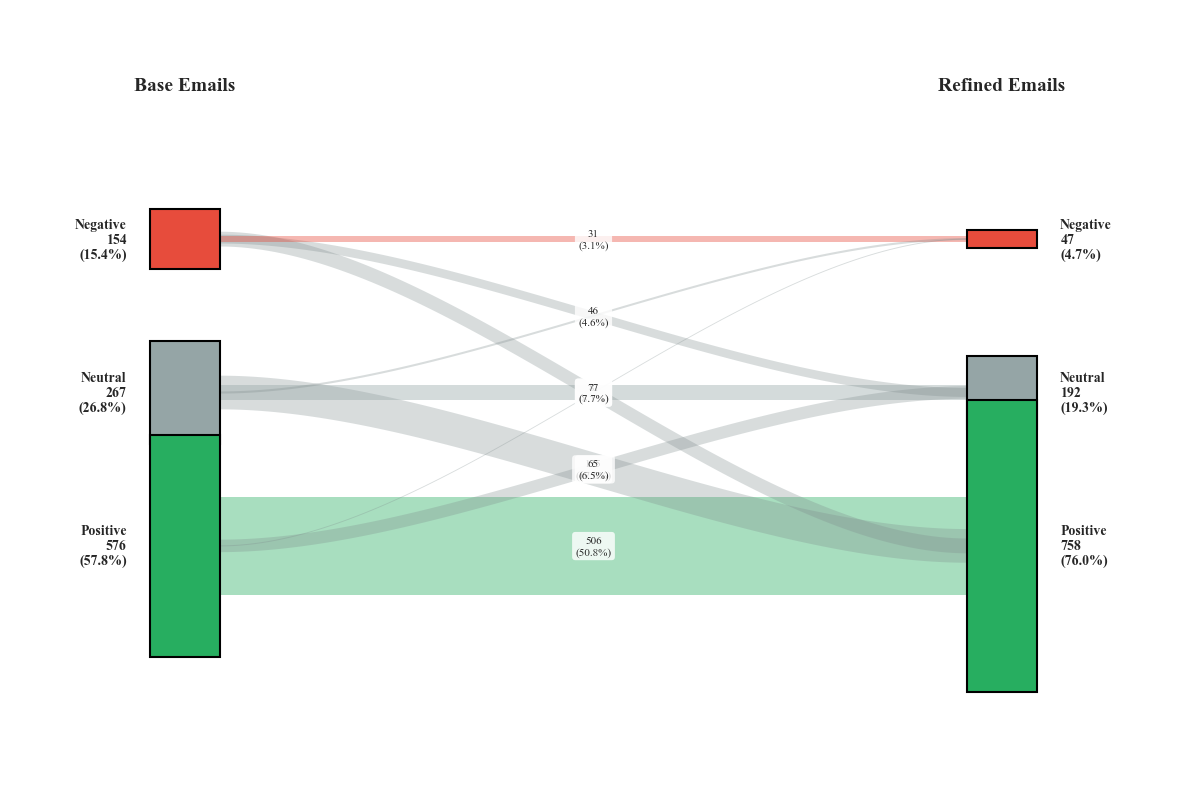

In [63]:
df_processed = analyze_matched_emails_with_sankey(df, save_path="gpt_llama8b_sankey.png")

In [66]:
df_processed[df_processed.category_change == "Negative → Positive"]

,custom_id,input_file,output_file,input_text,output_text,output_json,labels,input_sentiment_neg,input_sentiment_neu,input_sentiment_pos,output_sentiment_neg,output_sentiment_neu,output_sentiment_pos,input_sentiment_category,output_sentiment_category,category_change
12,12,batch_67c73522516481909ee9932df8c0fd36.jsonl,file-4XUEcgu2ar29qVANLS3tDn.json,"Email 1:\nHi Capt. Hu, We’r...",From: zoe@example.com\nTo: hu.gang@example.com...,"[{'from': 'zoe@example.com', 'to': 'hu.gang@ex...","{'broker': 'Zoe', 'commodity': 'Crude Palm Oil...",0.994155,0.005845,0.000000,0.111646,0.411646,0.476708,Negative,Positive,Negative → Positive
20,20,batch_67c73522516481909ee9932df8c0fd36.jsonl,file-4XUEcgu2ar29qVANLS3tDn.json,"Email 1:\nGreetings Mr. Davis, ...",From: harsha@example.com\nTo: joseph.ochieng@e...,"[{'from': 'harsha@example.com', 'to': 'joseph....","{'broker': 'Harsha', 'commodity': 'chemical dr...",0.986670,0.013330,0.000000,0.113788,0.413788,0.472423,Negative,Positive,Negative → Positive
49,49,batch_67c73522516481909ee9932df8c0fd36.jsonl,file-4XUEcgu2ar29qVANLS3tDn.json,"Email 1:\nHello CQAS, Is yo...",From: stephen@example.com\nTo: info@cqas-shipp...,"[{'from': 'stephen@example.com', 'to': 'info@c...","{'broker': '', 'commodity': 'barium nitrate', ...",0.733366,0.233317,0.033317,0.101379,0.401379,0.497242,Negative,Positive,Negative → Positive
55,55,batch_67c7377d85f08190b89b849f5b55c222.jsonl,file-GdJF4fUMJabeGVoBy64ZP4.json,Email 1:\nEmail D: Email E:...,From: sender@example.com\nTo: recipient@exampl...,"[{'from': 'sender@example.com', 'to': 'recipie...","{'broker': '', 'commodity': '', 'load_port': '...",0.997414,0.002586,0.000000,0.000000,0.004458,0.995542,Negative,Positive,Negative → Positive
56,56,batch_67c7377d85f08190b89b849f5b55c222.jsonl,file-GdJF4fUMJabeGVoBy64ZP4.json,"Email 1:\nGood morning Mr. Habib, ...",From: simon@example.com\nTo: habib@example.com...,"[{'from': 'simon@example.com', 'to': 'habib@ex...","{'broker': '', 'commodity': 'Heavy Fuel Oil', ...",0.910528,0.089472,0.000000,0.117362,0.417362,0.465276,Negative,Positive,Negative → Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,925,batch_67c794b4bf6881909f340169798059ca.jsonl,file-6P4Fh837K36T2tX1kxs22G.json,Email 1:\n<WRITE EMAIL> Cop...,From: rob@example.com\nTo: colleague@example.c...,"[{'from': 'rob@example.com', 'to': 'colleague@...","{'broker': '', 'commodity': '', 'load_port': '...",0.988519,0.011481,0.000000,0.000000,0.092682,0.907318,Negative,Positive,Negative → Positive
930,930,batch_67c794b4bf6881909f340169798059ca.jsonl,file-6P4Fh837K36T2tX1kxs22G.json,Email 1:\nYour text here...\nEmail 2:\nYour te...,From: johndoe@tradingcompany.com\nTo: janedoe@...,"[{'from': 'johndoe@tradingcompany.com', 'to': ...","{'broker': 'Jane Doe', 'commodity': 'steel coi...",0.764870,0.217565,0.017565,0.000000,0.028278,0.971722,Negative,Positive,Negative → Positive
934,934,batch_67c794b4bf6881909f340169798059ca.jsonl,file-6P4Fh837K36T2tX1kxs22G.json,"Email 1:\nHello Mr. Jones, ...",From: anne@shippingco.com\nTo: djones@freightf...,"[{'from': 'anne@shippingco.com', 'to': 'djones...","{'broker': '', 'commodity': 'shoes', 'load_por...",0.945202,0.054798,0.000000,0.000000,0.084447,0.915553,Negative,Positive,Negative → Positive
955,955,batch_67c7a07117008190804453a5634445db.jsonl,file-7MCnbuWfBYvvsVcjRNMqR5.json,"Email 1:\nHello Max, Your b...",From: joe@example.com\nTo: max@example.com\nSu...,"[{'from': 'joe@example.com', 'to': 'max@exampl...","{'broker': '', 'commodity': 'Diesel', 'load_po...",0.996885,0.003115,0.000000,0.124678,0.424678,0.450644,Negative,Positive,Negative → Positive


In [69]:
def create_static_sankey_adv(df_processed: pd.DataFrame, save_path: str = None):
        """Create a professional static Sankey diagram for thesis"""
        # Count transitions
        transitions = df_processed['category_change'].value_counts()
        total_count = len(df_processed)
        
        # Professional figure setup
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Positions
        left_x = 0.2
        right_x = 0.8
        
        # Muted colors with built-in alpha
        colors = {
            'Negative': '#e74c3c',
            'Neutral': '#7f8c8d',
            'Positive': '#27ae60'
        }
        
        # Get counts
        input_counts = df_processed['input_sentiment_category'].value_counts()
        output_counts = df_processed['output_sentiment_category'].value_counts()
        
        # Box dimensions
        box_width = 0.08
        total_height = 0.6  # Total height for all boxes
        
        # Calculate proportional heights and positions for stacked boxes
        sentiments = ['Positive', 'Neutral', 'Negative']  # Order from top to bottom
        
        # Input boxes - calculate positions
        input_y_positions = {}
        current_y = 0.7  # Start from top
        
        for sentiment in sentiments:
            count = input_counts.get(sentiment, 0)
            if count > 0:
                height = (count / total_count) * total_height
                input_y_positions[sentiment] = {
                    'center': current_y - height/2,
                    'top': current_y,
                    'bottom': current_y - height,
                    'height': height
                }
                current_y -= height
        
        # Output boxes - calculate positions
        output_y_positions = {}
        current_y = 0.7  # Start from top
        
        for sentiment in sentiments:
            count = output_counts.get(sentiment, 0)
            if count > 0:
                height = (count / total_count) * total_height
                output_y_positions[sentiment] = {
                    'center': current_y - height/2,
                    'top': current_y,
                    'bottom': current_y - height,
                    'height': height
                }
                current_y -= height
        
        # Draw input boxes
        for sentiment in sentiments:
            count = input_counts.get(sentiment, 0)
            if count > 0:
                pos_info = input_y_positions[sentiment]
                
                # Box with alpha
                rect = plt.Rectangle(
                    (left_x - box_width/2, pos_info['bottom']), 
                    box_width, pos_info['height'], 
                    facecolor=colors[sentiment], 
                    edgecolor='black', 
                    linewidth=1.0,
                    alpha=0.7,
                    zorder=5
                )
                ax.add_patch(rect)
                
                # Label with better formatting
                percentage = (count / total_count * 100) if total_count > 0 else 0
                label_text = f'{sentiment}\n{count} ({percentage:.0f}%)'
                
                ax.text(
                    left_x - box_width/2 - 0.03, 
                    pos_info['center'], 
                    label_text, 
                    ha='right', 
                    va='center', 
                    fontsize=11, 
                    fontweight='normal',
                    multialignment='center'
                )
        
        # Draw output boxes
        for sentiment in sentiments:
            count = output_counts.get(sentiment, 0)
            if count > 0:
                pos_info = output_y_positions[sentiment]
                
                # Box with alpha
                rect = plt.Rectangle(
                    (right_x - box_width/2, pos_info['bottom']), 
                    box_width, pos_info['height'], 
                    facecolor=colors[sentiment], 
                    edgecolor='black', 
                    linewidth=1.0,
                    alpha=0.7,
                    zorder=5
                )
                ax.add_patch(rect)
                
                # Label with better formatting
                percentage = (count / total_count * 100) if total_count > 0 else 0
                label_text = f'{sentiment}\n{count} ({percentage:.0f}%)'
                
                ax.text(
                    right_x + box_width/2 + 0.03, 
                    pos_info['center'], 
                    label_text, 
                    ha='left', 
                    va='center', 
                    fontsize=11, 
                    fontweight='normal',
                    multialignment='center'
                )
        
        # Draw flows
        for transition, count in transitions.items():
            if count == 0:
                continue
                
            source_sent, target_sent = transition.split(' → ')
            
            # Skip if sentiment not in position dictionaries
            if source_sent not in input_y_positions or target_sent not in output_y_positions:
                continue
                
            source_info = input_y_positions[source_sent]
            target_info = output_y_positions[target_sent]
            
            # Calculate flow positions
            flow_height = (count / total_count) * total_height
            
            # Position flow within the source box proportionally
            source_offset = (count / input_counts.get(source_sent, 1)) * source_info['height']
            source_y = source_info['top'] - source_offset/2
            
            # Position flow within the target box proportionally
            target_offset = (count / output_counts.get(target_sent, 1)) * target_info['height']
            target_y = target_info['top'] - target_offset/2
            
            # Flow styling
            if source_sent == target_sent:
                flow_color = colors[source_sent]
                alpha = 0.3
            else:
                flow_color = '#95a5a6'
                alpha = 0.25
            
            # Create smooth bezier curve
            num_points = 100
            t = np.linspace(0, 1, num_points)
            
            x1, y1 = left_x + box_width/2, source_y
            x2, y2 = right_x - box_width/2, target_y
            
            # Control points for smooth curve
            ctrl1_x = x1 + (x2 - x1) * 0.3
            ctrl1_y = y1
            ctrl2_x = x1 + (x2 - x1) * 0.7
            ctrl2_y = y2
            
            # Bezier curve calculation
            x = (1-t)**3 * x1 + 3*(1-t)**2*t * ctrl1_x + 3*(1-t)*t**2 * ctrl2_x + t**3 * x2
            y = (1-t)**3 * y1 + 3*(1-t)**2*t * ctrl1_y + 3*(1-t)*t**2 * ctrl2_y + t**3 * y2
            
            # Draw flow
            ax.fill_between(
                x, 
                y - flow_height/2, 
                y + flow_height/2, 
                color=flow_color, 
                alpha=alpha, 
                edgecolor='none', 
                zorder=1
            )
            
            # Add flow labels for significant flows
            if count > total_count * 0.05:  # Only label flows > 5%
                mid_x = (x1 + x2) / 2
                mid_y = (y1 + y2) / 2
                percentage = (count / total_count * 100)
                
                ax.text(
                    mid_x, 
                    mid_y, 
                    f'{count}\n({percentage:.0f}%)', 
                    ha='center', 
                    va='center', 
                    fontsize=9,
                    bbox=dict(
                        boxstyle="round,pad=0.3", 
                        facecolor='white', 
                        alpha=0.9, 
                        edgecolor='#cccccc',
                        linewidth=0.5
                    ),
                    zorder=10
                )
        
        # Column headers
        ax.text(left_x, 0.85, 'Base Emails', ha='center', va='center', 
               fontsize=13, fontweight='normal')
        ax.text(right_x, 0.85, 'Refined Emails', ha='center', va='center', 
               fontsize=13, fontweight='normal')
        
        # Set axis properties
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        
        # Remove extra whitespace
        plt.tight_layout()
        
        # Save with high quality
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
            print(f"Sankey diagram saved to: {save_path}")
        
        return fig

Sankey diagram saved to: gpt_sankey.png


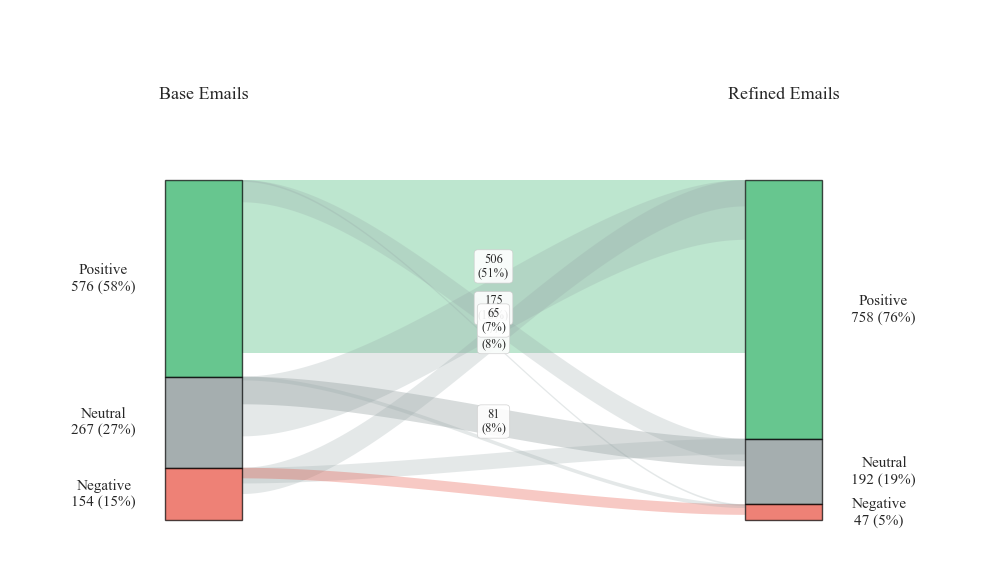

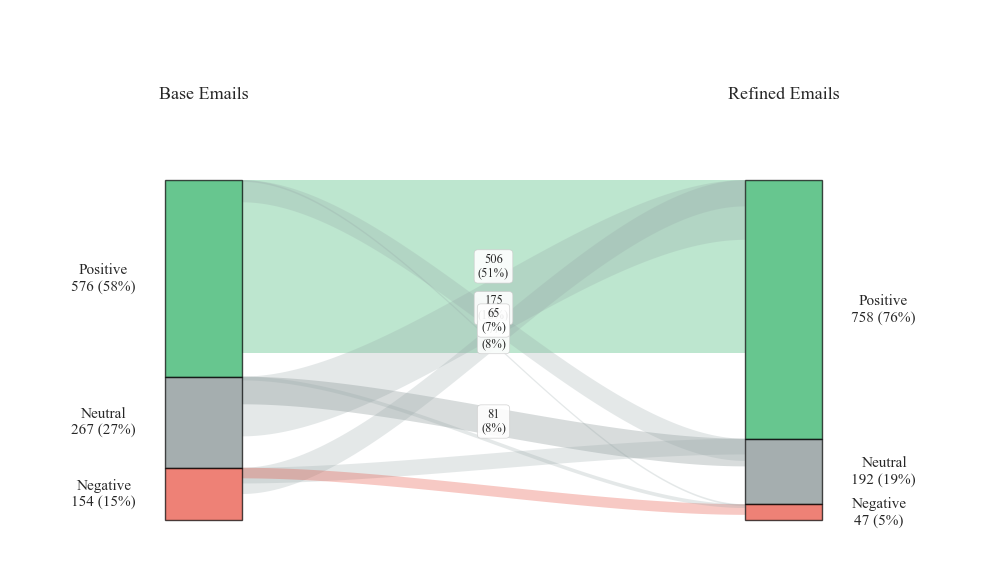

In [72]:
create_static_sankey_adv(df_processed, "gpt_sankey.png")